Ingreso de datos

In [46]:
import pandas as pd

# Cargar datos
df = pd.read_csv("train.csv")

# Mostrar información general del dataset
print("Dimensiones del dataset:", df.shape)
df.info()

# Resumen estadístico de las variables numéricas
df.describe()

# Valores faltantes por columna (ordenados)
conteoValoresVacios = df.isnull().sum().sort_values(ascending=False)

print("Columnas con mayor cantidad de datos vacios: ")
conteoValoresVacios[conteoValoresVacios > 0]


Dimensiones del dataset: (1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

LIMPIEZA DE DATOS

In [47]:
# Eliminar columnas con mayor cantidad de valores nulos
columnasMasVacias = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']
df2 = df.drop(columns=columnasMasVacias)

#columnas con valores numericos faltantes
columnasNumericas = df.select_dtypes(include=['int64', 'float64']).columns
df2[columnasNumericas] = df[columnasNumericas].fillna(df[columnasNumericas].mean())

#columnas con texto faltante
columnasTxt = df.select_dtypes(include=['object']).columns
df2[columnasTxt] = df[columnasTxt].fillna('Desconocido')

df2.isnull().sum().sort_values(ascending=False).head(5)


Id             0
MSSubClass     0
MSZoning       0
LotFrontage    0
LotArea        0
dtype: int64

SEPARACION DE CARACTERISTICAS Y VARIABLE OBJETIVO

In [48]:
# Separar variables predictoras (X) y objetivo (y)
X = df2.drop(columns=['SalePrice', 'Id'])  
y = df2['SalePrice']

X.shape, y.shape


((1460, 79), (1460,))

DATOS DE ENTRENAMIENTO

In [49]:
from sklearn.model_selection import train_test_split

X_codificado = pd.get_dummies(X,drop_first=True)

X_entreno, X_test, y_entreno, y_test = train_test_split(
    X_codificado, y, test_size=0.2, random_state=42
)

X_entreno.shape, X_test.shape


((1168, 260), (292, 260))

CONVERTIR COLUMNAS CATEGORICAS A VALORES NUMERICOS

In [50]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

modelo_arbol_regresor = DecisionTreeRegressor(random_state=42)
# Entrenar
modelo_arbol_regresor.fit(X_entreno, y_entreno)

# Predicción
y_prediccion = modelo_arbol_regresor.predict(X_test)

# Métricas
mae = mean_absolute_error(y_test, y_prediccion) #Error promedio
rmse = np.sqrt(mean_squared_error(y_test, y_prediccion)) #Error promedio (le da más importancia a los errores grandes)
r2 = r2_score(y_test, y_prediccion) #Mientras más cerca de 1, mejor predice los datos

print("ERROR PROMEDIO: " , mae) 
print("ERROR PROMEDIO CON ENFASIS EN VALORES GRANDES: ", rmse) 
print("COEFICIENTE DE DETERMINACIÓN: " , r2)


ERROR PROMEDIO:  27484.198630136987
ERROR PROMEDIO CON ENFASIS EN VALORES GRANDES:  41824.488903607
COEFICIENTE DE DETERMINACIÓN:  0.7719408764637864


CONSTRUCCION DE MODELO

In [51]:
from sklearn.ensemble import RandomForestRegressor


modelo_arbol_bosque_random = RandomForestRegressor(n_estimators=500, random_state=42) #500 arboles

modelo_arbol_bosque_random.fit(X_entreno, y_entreno)

y_prediccion_bosque_random = modelo_arbol_bosque_random.predict(X_test)


mae_bosque_random = mean_absolute_error(y_test, y_prediccion_bosque_random)
rmse_bosque_random = np.sqrt(mean_squared_error(y_test, y_prediccion_bosque_random))
r2_bosque_random = r2_score(y_test, y_prediccion_bosque_random)

print("ERROR PROMEDIO: " , mae_bosque_random) 
print("ERROR PROMEDIO CON ENFASIS EN VALORES GRANDES: ", rmse_bosque_random) 
print("COEFICIENTE DE DETERMINACIÓN: " , r2_bosque_random)

ERROR PROMEDIO:  17499.380883561644
ERROR PROMEDIO CON ENFASIS EN VALORES GRANDES:  28974.63981463349
COEFICIENTE DE DETERMINACIÓN:  0.8905483639533999


Interpretación

El Random Forest predice con 89% de precisión y se equivoca en promedio $16,468.

En comparación, el RandomForest es un 31% más preciso que el TreeRegressor, ya que incluso la diferencia de margen de error es de aproximadamente $12,000. 

Esto significa que:

- El modelo de RandomForest generaliza mejor
- Los errores grandes se redujeron

VARIABLES IMPORTANTES

In [52]:
import pandas as pd

importancias_categoricas = modelo_arbol_bosque_random.feature_importances_

tabla_importancias = pd.DataFrame({
    'Característica': X_entreno.columns,
    'Importancia': importancias_categoricas
}).sort_values('Importancia', ascending = False)

tabla_importancias.head(20)



,Característica,Importancia
3,OverallQual,0.554652
15,GrLivArea,0.122728
11,TotalBsmtSF,0.034129
13,2ndFlrSF,0.031393
8,BsmtFinSF1,0.027883
12,1stFlrSF,0.027861
2,LotArea,0.017012
26,GarageArea,0.016033
25,GarageCars,0.015323
5,YearBuilt,0.013444


La tabla que aparece es el ranking de las características que más influyen en el precio de la casa, Esto significa que el estado general del acabado (OverallQual) y  la superficie habitable por encima del nivel del suelo(GrLivArea) está siendo evaluado por el modelo como unas de las variables más relevantes para predecir el SalePrice del dataset.

GRAFICA DE VARIABLES

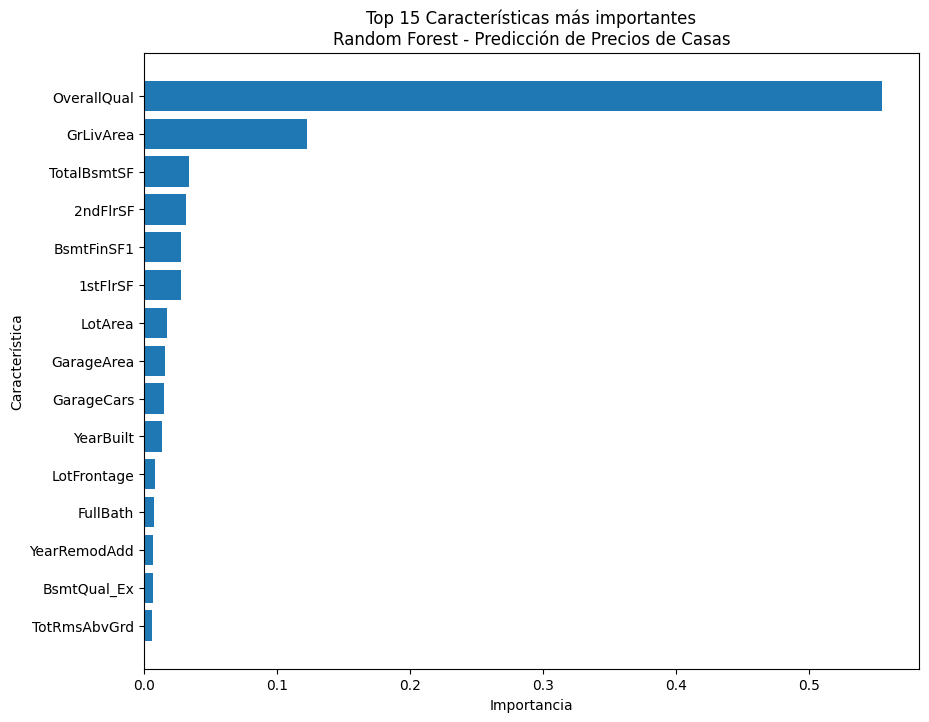

In [53]:
import matplotlib.pyplot as plt

# Top 15 características
top = 15
top_caracteristicas = tabla_importancias.head(top).sort_values('Importancia')

plt.figure(figsize=(10, 8))

plt.barh(top_caracteristicas['Característica'], top_caracteristicas['Importancia'])

plt.xlabel('Importancia')

plt.ylabel('Característica')

plt.title('Top 15 Características más importantes\nRandom Forest - Predicción de Precios de Casas')

plt.show()


In [54]:
top20 = tabla_importancias.head(20)

top20


,Característica,Importancia
3,OverallQual,0.554652
15,GrLivArea,0.122728
11,TotalBsmtSF,0.034129
13,2ndFlrSF,0.031393
8,BsmtFinSF1,0.027883
12,1stFlrSF,0.027861
2,LotArea,0.017012
26,GarageArea,0.016033
25,GarageCars,0.015323
5,YearBuilt,0.013444


GRAFICA DE IMPORTANCIA

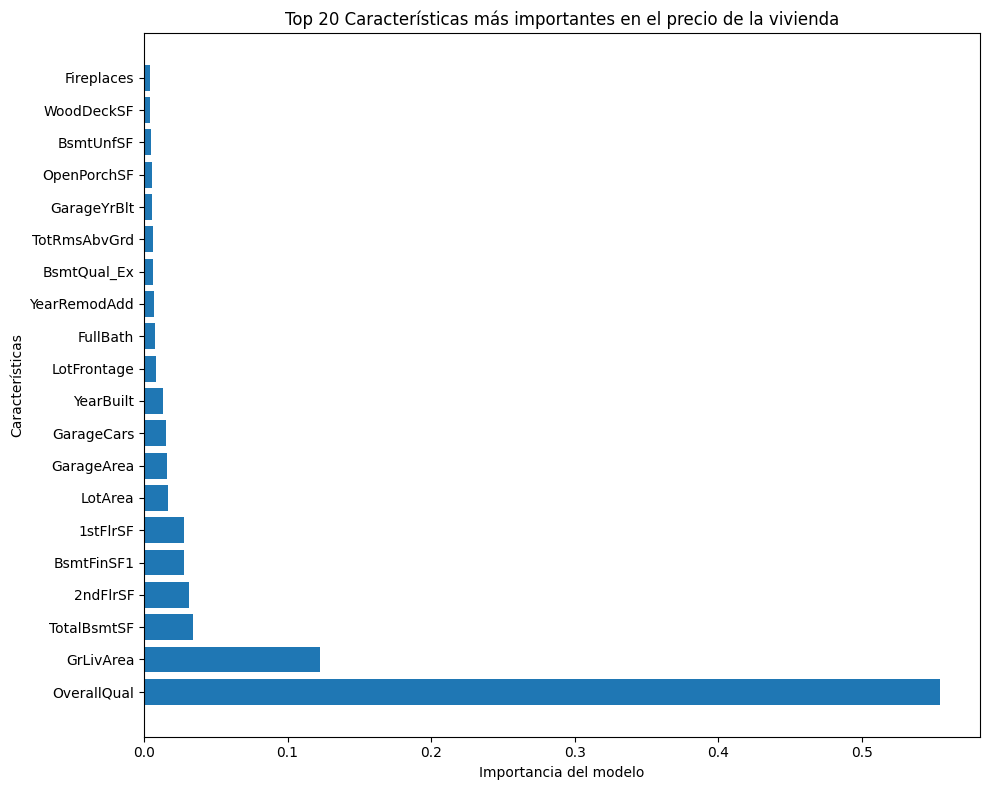

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

plt.barh(top20['Característica'], top20['Importancia'])

plt.title("Top 20 Características más importantes en el precio de la vivienda")

plt.xlabel("Importancia del modelo")

plt.ylabel("Características")

plt.tight_layout()

plt.show()




El modelo muestra que los atributos vinculados al area habitable, como la calidad del material y acabados (OverallQual), el area habitable sobre el nivel del suelo(GarageFinish) y los pies cuadrados del sotano (TotalBsmtSF) tienen un impacto significativo en el valor de la vivienda.  Por lo tanto, son rasgos importantes que resaltan la importancia del estado estructural y del mantenimiento de la propiedad para determinar su precio final.

Comparacion de modelos

In [56]:
# Comparar modelos: DecisionTree, RandomForest, GradientBoosting
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold

modelos = {
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=200, random_state=42)
}



resultados = []

def evaluar_modelos(nombre, estimator):
    # Entrenamiento en el split
    estimator.fit(X_entreno, y_entreno)
    y_prediccion = estimator.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_prediccion)
    rmse = np.sqrt(mean_squared_error(y_test, y_prediccion))
    r2 = r2_score(y_test, y_prediccion)
    
    # Validación cruzada. Se divide el dataset en n_splits = 5 
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_r2 = cross_val_score(estimator, X_entreno, y_entreno, cv=kf, scoring='r2').mean()
    
    resultados.append({
        'Modelo': nombre,
        'MAE': mae,
        'RMSE': rmse,
        'R2_test': r2,
        'R2_promedio': cv_r2
    })

    return r2, cv_r2



for nombre, estimator in modelos.items():
    r2, cv_r2 = evaluar_modelos(nombre, estimator)
    print(f"{nombre} terminado -> R2_test: {r2:.4f}, R2_cv5: {cv_r2:.4f}")


# Resumen en DataFrame ordenado por RMSE ascendente
tabla_resultados = pd.DataFrame(resultados).sort_values('RMSE')
tabla_resultados


DecisionTree terminado -> R2_test: 0.7719, R2_cv5: 0.7086
RandomForest terminado -> R2_test: 0.8907, R2_cv5: 0.8414
GradientBoosting terminado -> R2_test: 0.9048, R2_cv5: 0.8722


,Modelo,MAE,RMSE,R2_test,R2_promedio
2,GradientBoosting,16688.681173,27028.640369,0.904757,0.872158
1,RandomForest,17650.978202,28956.547587,0.890685,0.841412
0,DecisionTree,27484.198630,41824.488904,0.771941,0.708600


TUNING DE HIPERPARAMETROS PARA EL MEJOR MODELO "GradientBoosting"

In [57]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform

# Pipeline base

modeloGradientBoosting = GradientBoostingRegressor(random_state=42)
# Espacio de búsqueda de hiperparámetros
hiperparametros = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.15),
    'max_depth': randint(2, 8),
    'subsample': uniform(0.6, 0.4),
    'min_samples_split': randint(2, 20)
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator = modeloGradientBoosting,
    param_distributions = hiperparametros,
    n_iter = 40, 
    scoring = 'r2',
    cv = kf,
    n_jobs = -1,
    random_state = 42,
    verbose = 2
)


random_search.fit(X_entreno, y_entreno)


mejor_modelo = random_search.best_estimator_

print("Mejores hiperparametros:", random_search.best_params_)
print("Mejor R2 Promedio:", random_search.best_score_)

# Evaluación final en test
y_mejor_prediccion = mejor_modelo.predict(X_test)
mejor_MAE = mean_absolute_error(y_test, y_mejor_prediccion)
mejor_RMSE = np.sqrt(mean_squared_error(y_test, y_mejor_prediccion))
mejor_R2 = r2_score(y_test, y_mejor_prediccion)

mejor_MAE, mejor_RMSE, mejor_R2


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Mejores hiperparametros: {'learning_rate': np.float64(0.12975176874768266), 'max_depth': 2, 'min_samples_split': 7, 'n_estimators': 448, 'subsample': np.float64(0.943343521925488)}
Mejor R2 Promedio: 0.8878557742125489


(16954.97028312297, np.float64(28383.507901214245), 0.8949688058868449)

INTERPRETACION DE CARACTERISTICAS

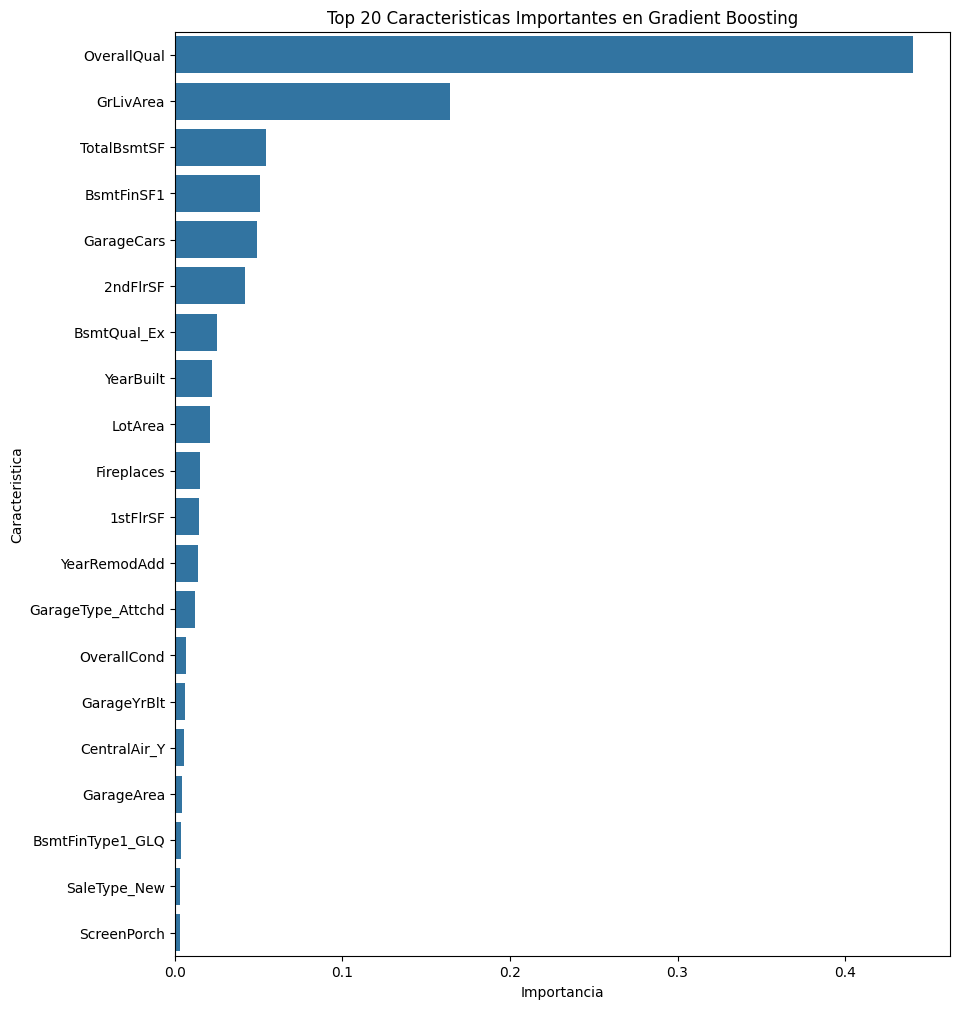

,Caracteristica,Importancia
3,OverallQual,0.440537
15,GrLivArea,0.163983
11,TotalBsmtSF,0.054429
8,BsmtFinSF1,0.051069
25,GarageCars,0.049281
13,2ndFlrSF,0.042035
160,BsmtQual_Ex,0.024869
5,YearBuilt,0.021921
2,LotArea,0.020845
23,Fireplaces,0.015020


In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extraemos el modelo interno
modelo_de_Gradient_Boosting = mejor_modelo
# Importancia de características
Importancias = modelo_de_Gradient_Boosting.feature_importances_
Caracteristicas = X_entreno.columns

tabla_importancias2 = pd.DataFrame({
    'Caracteristica': Caracteristicas,
    'Importancia': Importancias
}).sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importancia', y='Caracteristica', data=tabla_importancias2.head(20))
plt.title('Top 20 Caracteristicas Importantes en Gradient Boosting')
plt.show()

tabla_importancias2.head(20)


CALCULO DE SHAP

In [59]:
%pip install shap


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


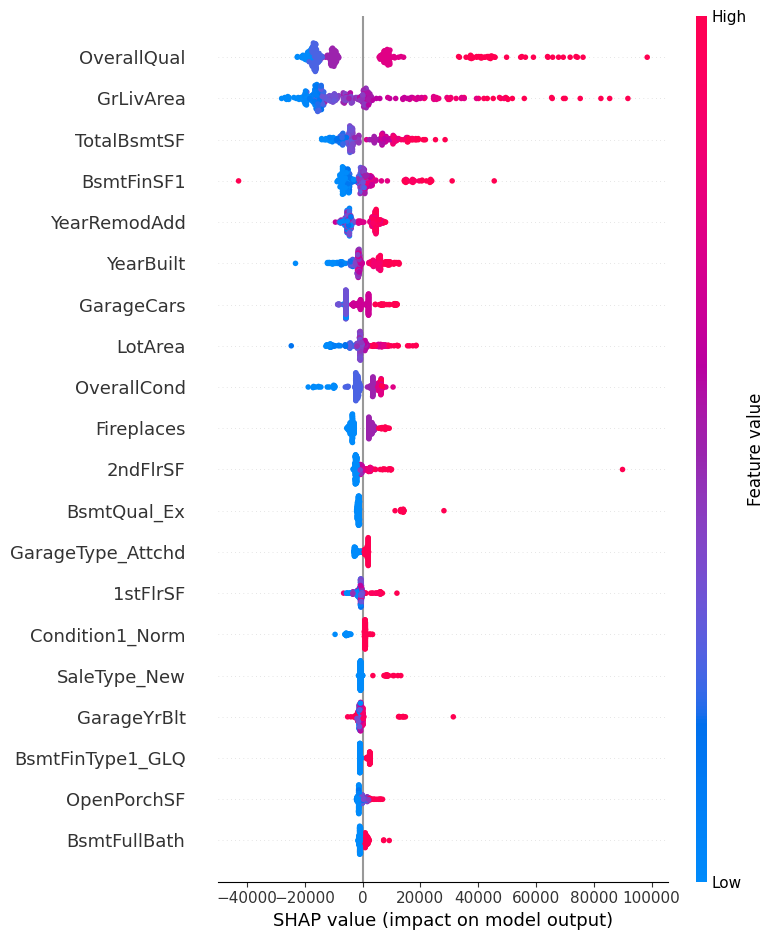

In [60]:
import shap
import matplotlib.pyplot as plt
import numpy as np

modelo_de_Gradient_Boosting

# Transformar el conjunto de prueba (devuelve csr_matrix)
X_test_processed = X_test

# Convertir a denso y asegurar tipo float
X_test_processed = X_test_processed.values.astype(float)

# Nuevos nombres de columnas tras OneHotEncoding
feature_names_shap = X_test.columns

# Crear explainer
explainer = shap.TreeExplainer(modelo_de_Gradient_Boosting)

# Obtener valores SHAP
shap_values = explainer.shap_values(X_test_processed)

# Gráfico resumen
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_processed, feature_names=feature_names_shap, plot_type="dot")


IMPACTO INDIVIDUAL DE VARIABLES

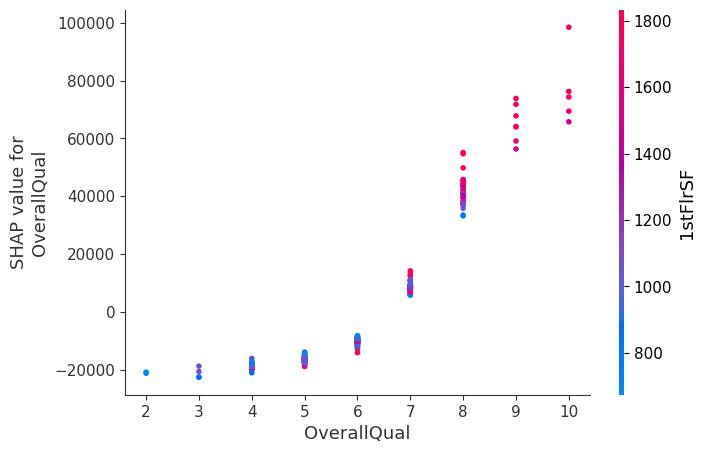

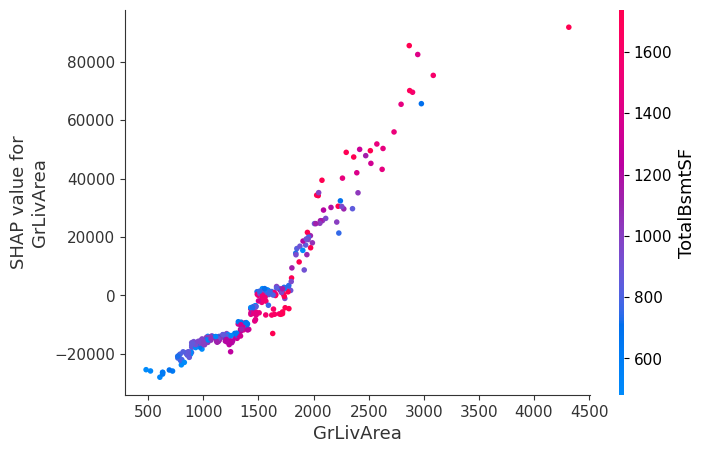

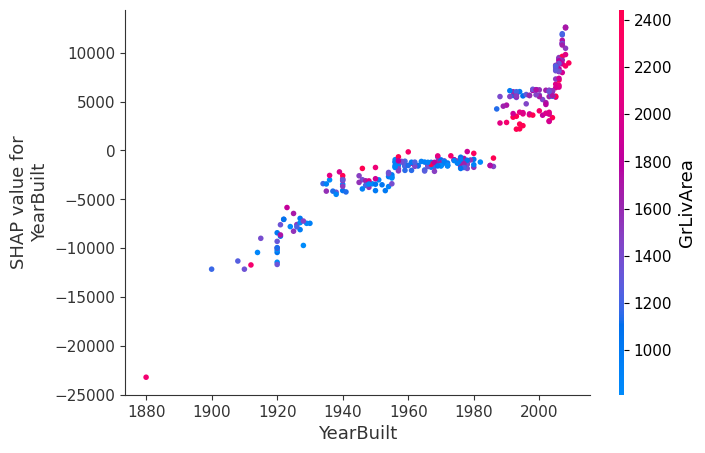

In [62]:
features_to_plot = ['OverallQual', 'GrLivArea', 'YearBuilt']

for feat in features_to_plot:
    shap.dependence_plot(feat, shap_values, X_test_processed, feature_names=feature_names_shap)


El modelo aprende que el precio de una casa se explica principalmente por su calidad, su tamaño y su antigüedad. Además, SHAP nos revela interacciones: no es solo tener una casa grande, sino tambien bien construida, no es solo que sea nueva, sino con espacios acabados. 

Error del modelo en función del precio real: Esto ayuda a mostrar si el modelo falla más en casas baratas o caras.

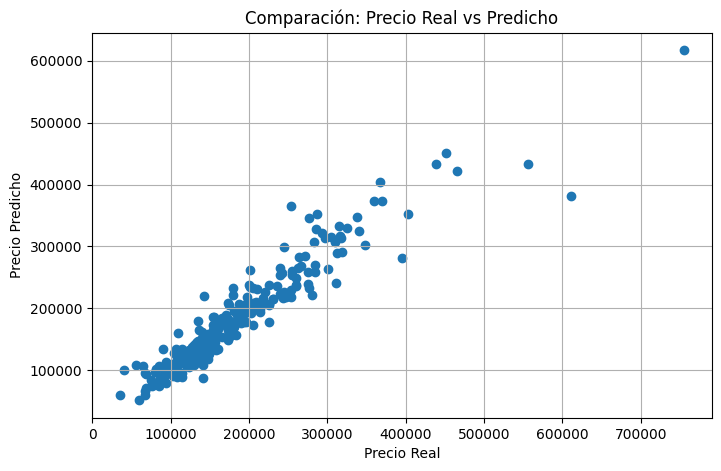

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(y_test, y_mejor_prediccion)
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho")
plt.title("Comparación: Precio Real vs Predicho")
plt.grid(True)
plt.show()


Distribución de errores (residuos): Sirve para validar si el modelo se comporta de forma estable.

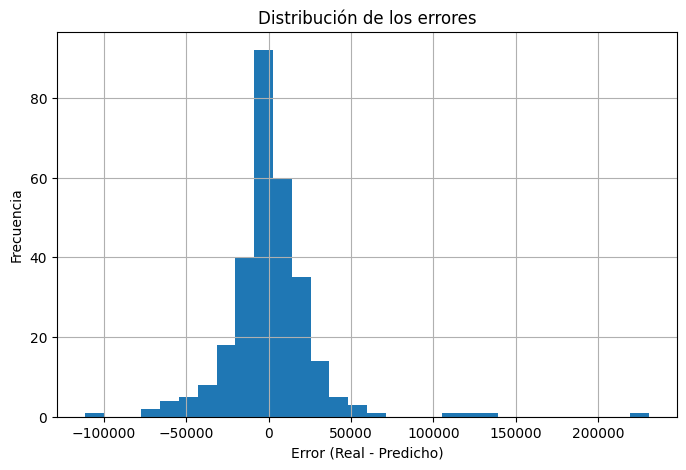

In [64]:
errors = y_test - y_mejor_prediccion

plt.figure(figsize=(8,5))
plt.hist(errors, bins=30)
plt.xlabel("Error (Real - Predicho)")
plt.ylabel("Frecuencia")
plt.title("Distribución de los errores")
plt.grid(True)
plt.show()
